# Coupon Offer Sensitivity Analysis

## Overview

Given data from coupon usage and amount spent. In this workbook need to understand the sensitivity of the customers: 

1) Negative: Spend decerases with OfferAmt
2) Positive: Spend increases with OfferAmt
3) Insensitive: No change with changing OfferAmt

To achieve this I think the best approach is to to a linear regression. In these cases it can sometimes be better to use RANSAC, as it deals better with outliers. This takes longer, but the data size ~is small. 

In [79]:
import pandas as pd
import numpy as np

In [80]:
df = pd.read_csv("../data/HistoricalTrainingData.csv")

In [81]:
print(df.head())
print(len(df))

   PatronID UseStartDate  UseEndDate  OfferAmt    TripDate  Spend  \
0  10014453   2017-09-11  2017-09-17      40.0  2017-09-12   9.92   
1  10049508   2017-09-11  2017-09-17      75.0         NaN    NaN   
2  10138716   2017-09-11  2017-09-17      45.0         NaN    NaN   
3  10157508   2017-09-11  2017-09-17       5.0         NaN    NaN   
4  10160334   2017-09-11  2017-09-17      55.0         NaN    NaN   

   OfferAmtRedeemed RedeemedYN  
0              40.0          Y  
1               NaN          N  
2               NaN          N  
3               NaN          N  
4               NaN          N  
110260


Looks like there are a number of NaNs

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

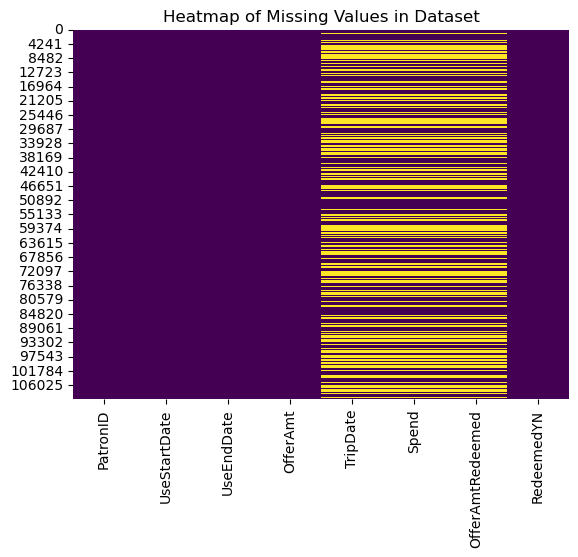

In [83]:

# Draw a heatmap with the missing values (True if missing, False if not missing)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

plt.title('Heatmap of Missing Values in Dataset')
plt.show()

In [84]:
# Calculate the percentage of missing values for each specified column
missing_percentage_tripdate = df['TripDate'].isnull().mean() * 100
missing_percentage_spend = df['Spend'].isnull().mean() * 100
missing_percentage_offeramt = df['OfferAmtRedeemed'].isnull().mean() * 100

# Print the percentages
print(f"Percentage of missing values in TripDate: {missing_percentage_tripdate:.2f}%")
print(f"Percentage of missing values in Spend: {missing_percentage_spend:.2f}%")
print(f"Percentage of missing values in OfferAmtRedeemed: {missing_percentage_offeramt:.2f}%")

Percentage of missing values in TripDate: 46.06%
Percentage of missing values in Spend: 46.06%
Percentage of missing values in OfferAmtRedeemed: 46.06%


This missing data is related to the redeemedYN, need to convert these to 0.

In [85]:
def preprocess_data(df):
    # Make a copy of the DataFrame to avoid modifying the original data
    df_processed = df.copy()
    
    # Fill missing values for 'Spend' and 'OfferAmtRedeemed' with 0
    df_processed['Spend'] = df_processed['Spend'].fillna(0)
    df_processed['OfferAmtRedeemed'] = df_processed['OfferAmtRedeemed'].fillna(0)
    
    # Create a 'TripDateMissing' indicator: 1 if 'TripDate' is missing, 0 otherwise
    df_processed['TripDateMissing'] = df_processed['TripDate'].isnull().astype(int)
    
    return df_processed

df = preprocess_data(df)

## Exploratory Data Analysis

What to understand how things are distributed in the data. First let's look at the number of visits.

In [86]:
def aggregate_customer_data(df):
    # Aggregate data by PatronID to calculate total spend, total offer amount redeemed, and number of visits
    customer_aggregates = df.groupby('PatronID').agg(
        TotalSpend=pd.NamedAgg(column='Spend', aggfunc='sum'),
        TotalOfferAmtRedeemed=pd.NamedAgg(column='OfferAmtRedeemed', aggfunc='sum'),
        NumberOfVisits=pd.NamedAgg(column='Spend', aggfunc='count')  # Counting rows per customer
    ).reset_index()
    
    # Calculate SpendPerPoundCoupon for each customer
    # Avoid division by zero for customers who never redeemed a coupon
    customer_aggregates['SpendPerPoundCoupon'] = np.where(customer_aggregates['TotalOfferAmtRedeemed'] > 0,
                                                          customer_aggregates['TotalSpend'] / customer_aggregates['TotalOfferAmtRedeemed'],
                                                          0)
    
    # Replace infinite values or NaNs with 0 or an appropriate placeholder
    customer_aggregates['SpendPerPoundCoupon'].replace([np.inf, -np.inf], np.nan, inplace=True)
    customer_aggregates['SpendPerPoundCoupon'].fillna(0, inplace=True)  # Fill NaNs with 0
    
    return customer_aggregates

df_aggregated = aggregate_customer_data(df)

# Sort the customers based on SpendPerPoundCoupon to see the results, including the number of visits
sorted_customers = df_aggregated.sort_values(by='SpendPerPoundCoupon', ascending=False).reset_index(drop=True)

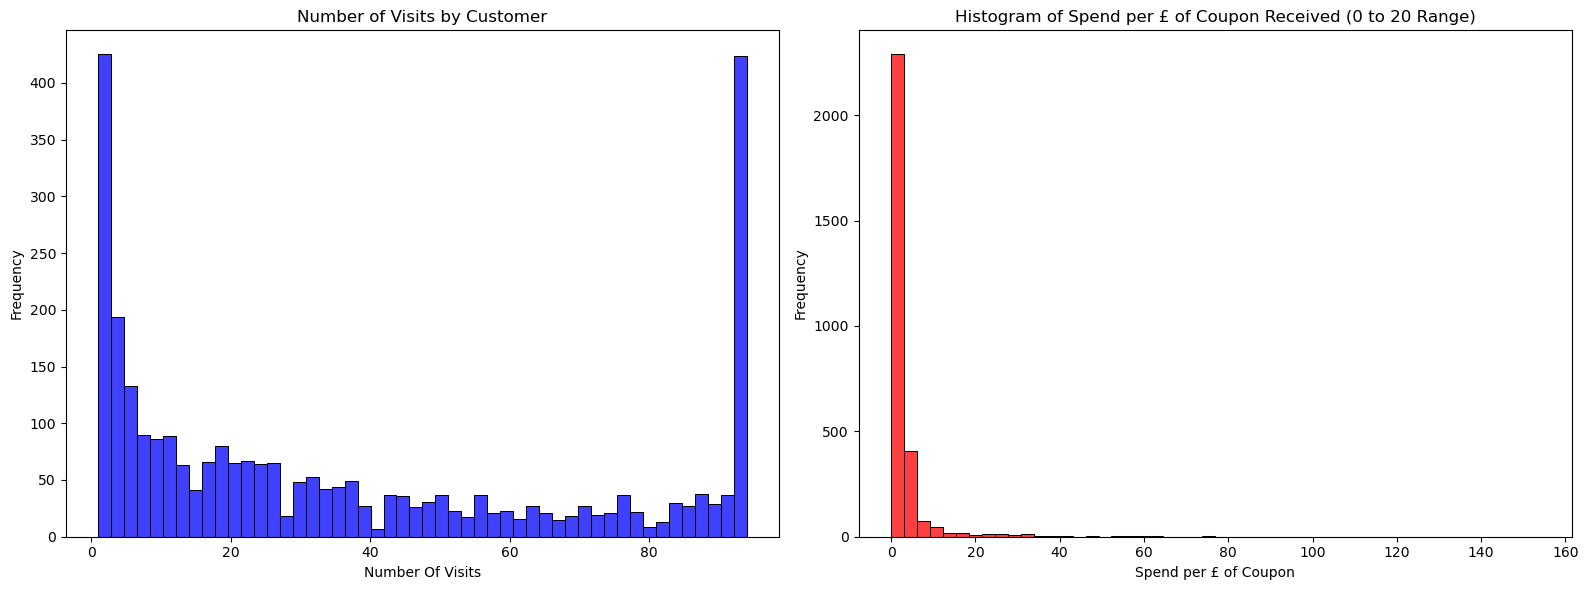

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Number of Visits histogram on the first subplot
sns.histplot(sorted_customers['NumberOfVisits'], bins=50, kde=False, color="blue", ax=axes[0])
axes[0].set_title('Number of Visits by Customer')
axes[0].set_xlabel('Number Of Visits')
axes[0].set_ylabel('Frequency')

# Plotting Spend per £ of Coupon Received histogram on the second subplot
sns.histplot(sorted_customers['SpendPerPoundCoupon'], bins=50, kde=False, color="red", ax=axes[1])
axes[1].set_title('Histogram of Spend per £ of Coupon Received (0 to 20 Range)')
axes[1].set_xlabel('Spend per £ of Coupon')
axes[1].set_ylabel('Frequency')

# Adjust layout for better readability
plt.tight_layout()
plt.show()



This tells me that there are a number of so-so customers and very loyal customers. 94 represents people who have bought every week. Additionall these customers have a high Spend per £ of Coupon. 

## SENSITIVITY MEASUREMENTS

I need to understand how spending amount changes with offered amount redeemed for each customer. Performing a linear regression will tell me whether they increase, decrease or don't change spend based on the coupon. To do this I will use RANSACC

Note: I tried linear regression and it wasn't robust enough, I was getting a lot of extreme gradients affected by outliers

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import warnings

In [89]:

def calculate_customer_metrics(df):
    # Filter out customers who have not redeemed any coupons
    df_with_coupons = df[df['OfferAmtRedeemed'] > coupon_amount]
    
    # Group by 'PatronID' and filter groups with more than 3 visits
    def filter_visits(group):
        if len(group) > coupon_trips:  # Adjusted to more than x visits based on your updated criteria
            return True
        else:
            return False
    
    filtered_groups = df_with_coupons.groupby('PatronID').filter(filter_visits)
    
    # Function to calculate metrics for each customer using RANSAC
    def calculate_metrics(group):
        X = group['OfferAmt'].values.reshape(-1, 1)  # Independent variable
        y = group['Spend'].values  # Dependent variable
        
           # Suppress warnings for this block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # Use RANSACRegressor for robust linear regression
            model = RANSACRegressor().fit(X, y)
            
            # Assuming you want to extract the gradient (slope) from the RANSAC model
            gradient = model.estimator_.coef_[0]
            intercept = model.estimator_.intercept_
        
        # Calculating additional metrics
        total_visits = group.shape[0]
        total_spend = group['Spend'].sum()
        total_offer_amt_redeemed = group['OfferAmtRedeemed'].sum()
        spend_per_offer = total_spend / total_offer_amt_redeemed if total_offer_amt_redeemed else 0
        
        return pd.Series({
            'Gradient': gradient,
            'Intercept':intercept, 
            'NumberOfVisits': total_visits,
            'TotalSpend': total_spend,
            'TotalOfferAmtRedeemed': total_offer_amt_redeemed,
            'SpendPerOffer': spend_per_offer
        })

    # Apply the metrics calculation function to each filtered customer group
    customer_metrics = filtered_groups.groupby('PatronID').apply(calculate_metrics).reset_index()
    
    return customer_metrics

# Assuming 'df' is your DataFrame with 'PatronID', 'OfferAmt', 'OfferAmtRedeemed', and 'Spend' columns
customer_metrics_df = calculate_customer_metrics(df)


In [90]:
# Selecting only PatronID and sensitivity_gradient columns
export_df = customer_metrics_df[['PatronID', 'Gradient', 'Intercept']]
export_df.to_csv('customer_sensitivity_metrics.csv', index=False)
export_df

,PatronID,Gradient,Intercept
0,10014453,0.136559,12.970105
1,10049508,0.822601,0.241671
2,10138716,0.175415,30.681759
3,10160334,0.577929,23.421836
4,10232802,1.192778,-4.297015
...,...,...,...
1252,23295672,0.131451,-0.674559
1253,23312961,8.971238,-1365.116039
1254,23358483,0.766731,-198.079254
1255,23373603,-2.298532,1042.810282


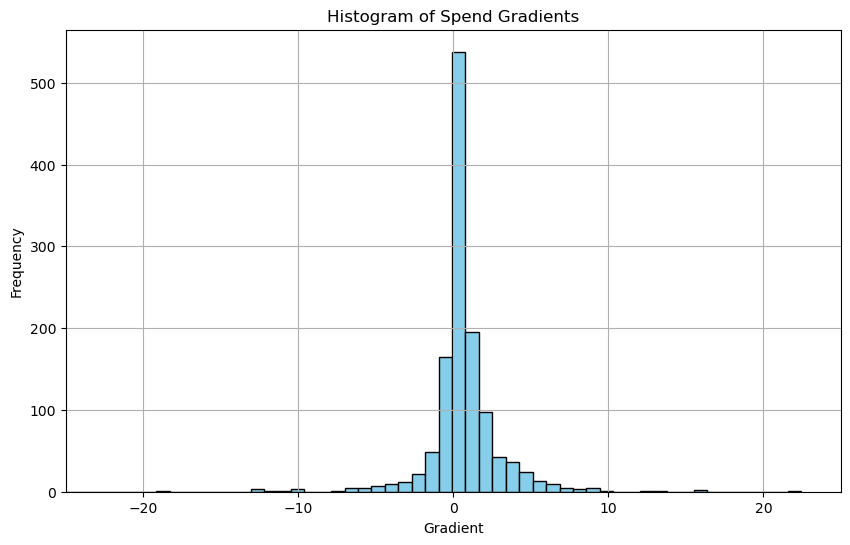

In [91]:
# Assuming 'customer_metrics_df' is your DataFrame and it includes a 'Gradient' column
plt.figure(figsize=(10, 6))
plt.hist(customer_metrics_df['Gradient'], bins=75, color='skyblue', edgecolor='black')
plt.title('Histogram of Spend Gradients')
plt.xlabel('Gradient')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-25, 25)
plt.show()

This is the training data spread, looks like a normal distribution with a slight skew

Let's create a function to determine what the sensitivity category is. I am going to pick -0.1 and 0.5. If I had more time I would want to dig into this, but looking at the data this feels sensible. 

In [92]:
coupon_amount = 0
coupon_trips = 4
negative_sensitivity = -0.1
positive_sensitivity = 0.5

# Function to classify sensitivity based on new thresholds
def classify_sensitivity(gradient):
    if gradient <= negative_sensitivity:
        return 'Negatively Sensitive'
    elif gradient >= positive_sensitivity:
        return 'Positively Sensitive'
    else:
        return 'Insensitive'

# Apply the new classification to each customer
customer_metrics_df['Sensitivity_Classification'] = customer_metrics_df['Gradient'].apply(classify_sensitivity)

In [93]:
# Examine the distribution of sensitivity categories accounting for skewness
print(customer_metrics_df['Sensitivity_Classification'].value_counts())
print(customer_metrics_df['Gradient'].median())

Positively Sensitive    535
Insensitive             441
Negatively Sensitive    281
Name: Sensitivity_Classification, dtype: int64
0.3102827467873832


## Test Algorithmn on test data

Let's do this calculation for the test data and see if we get the same distribution of results

In [94]:
df_test = pd.read_csv("../data/TestingData.csv")

combined_df = pd.concat([df, df_test], ignore_index=True)

I first want to understand if there is signficant overlap between customers in the test and training data

In [95]:
# Assuming combined_df represents the combined dataset of training and test data
# And df_test represents the test dataset specifically

# 1) Total customers in test
total_customers_test = df_test['PatronID'].nunique()

# 2) Total customers in test that used a coupon (based on combined data)
# First, filter the combined data for coupon redemptions, then filter for only test customers
combined_with_coupon_redemptions = combined_df[combined_df['OfferAmt'] > coupon_amount]
test_patron_ids = df_test['PatronID'].unique()
test_customers_who_used_coupon = combined_with_coupon_redemptions[combined_with_coupon_redemptions['PatronID'].isin(test_patron_ids)]
total_test_customers_who_used_coupon = test_customers_who_used_coupon['PatronID'].nunique()

# 3) Total customers in test that used a coupon and had more than three visits where they used a coupon
# Count the number of coupon redemptions per customer in the filtered combined dataset, then filter for more than 3 visits
coupon_redemptions_per_test_customer = test_customers_who_used_coupon.groupby('PatronID').size()
customers_with_more_than_3_coupon_uses = coupon_redemptions_per_test_customer[coupon_redemptions_per_test_customer > coupon_trips].count()

print(f"Total customers in test: {total_customers_test}")
print(f"Total customers in test that used a coupon: {total_test_customers_who_used_coupon}")
print(f"Total customers in test that used a coupon and had more than three visits where they used a coupon: {customers_with_more_than_3_coupon_uses}")

Total customers in test: 3499
Total customers in test that used a coupon: 2490
Total customers in test that used a coupon and had more than three visits where they used a coupon: 1940


There is overlap, so we can proceed

## Running Test Calculations

In [96]:
# Calculate customer metrics for the combined dataset
combined_customer_metrics_df = calculate_customer_metrics(combined_df)

# Apply the new classification to each customer
combined_customer_metrics_df['Sensitivity_Classification'] = combined_customer_metrics_df['Gradient'].apply(classify_sensitivity)


Make sure we are only dealing with customers in the test data set. All other customers we have the label unknown

In [97]:
test_customer_sensitivity = combined_customer_metrics_df[combined_customer_metrics_df['PatronID'].isin(df_test['PatronID'])]

Let's have a lookt to see if the test data set and training set over lap in terms of distribution. It looks like they do, so I am happy with this approach

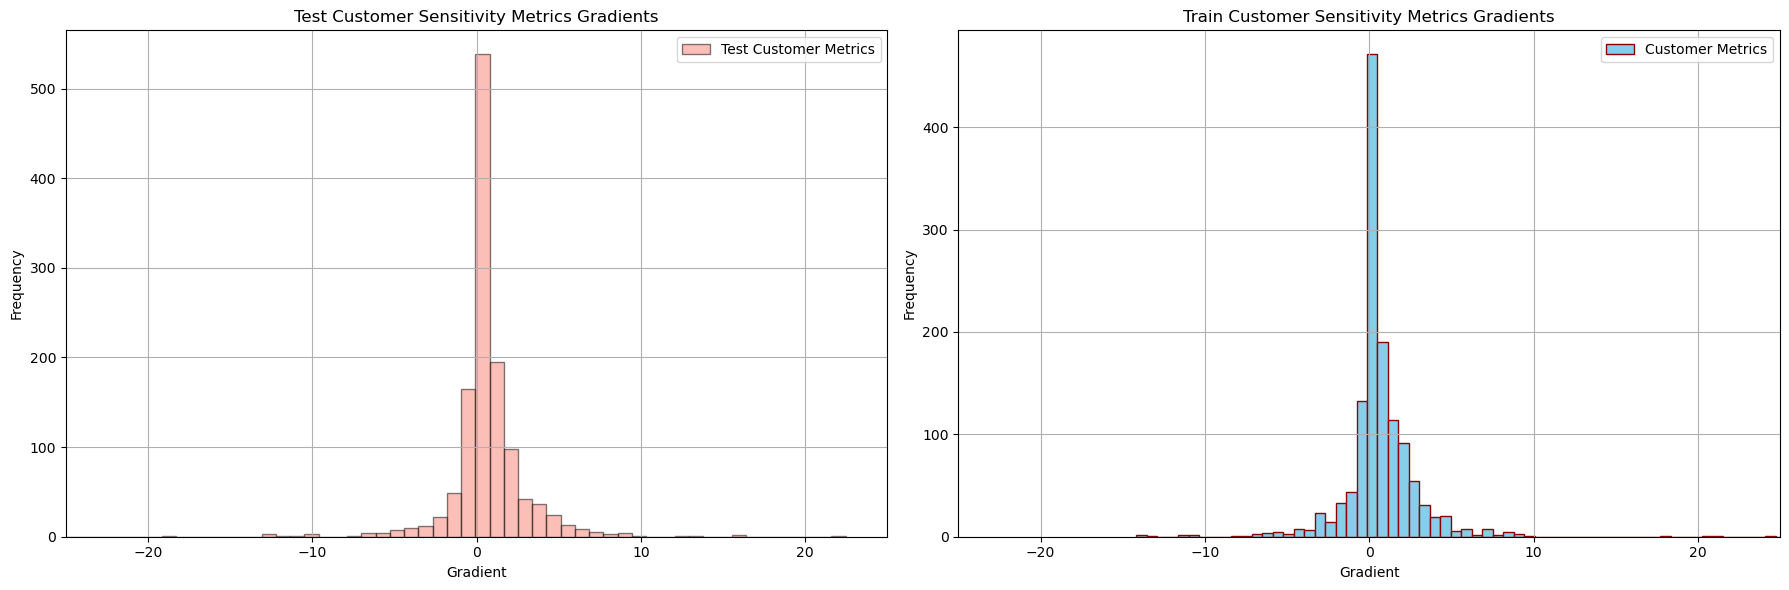

In [98]:
import matplotlib.pyplot as plt

# Assuming customer_metrics_df and test_customer_~sensitivity are already defined and contain the 'Gradient' column.

plt.figure(figsize=(18, 6))

# Plot for Test Customer Metrics
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(customer_metrics_df['Gradient'], bins=75, color='salmon', alpha=0.5, edgecolor='black', label='Test Customer Metrics')
plt.title('Test Customer Sensitivity Metrics Gradients')
plt.xlabel('Gradient')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-25, 25)
plt.legend()

# Plot for Customer Metrics
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(test_customer_sensitivity['Gradient'], bins=75, color='skyblue', alpha=1, edgecolor='darkred', label='Customer Metrics')
plt.title('Train Customer Sensitivity Metrics Gradients')
plt.xlabel('Gradient')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-25, 25)
plt.legend()

plt.tight_layout()
plt.show()



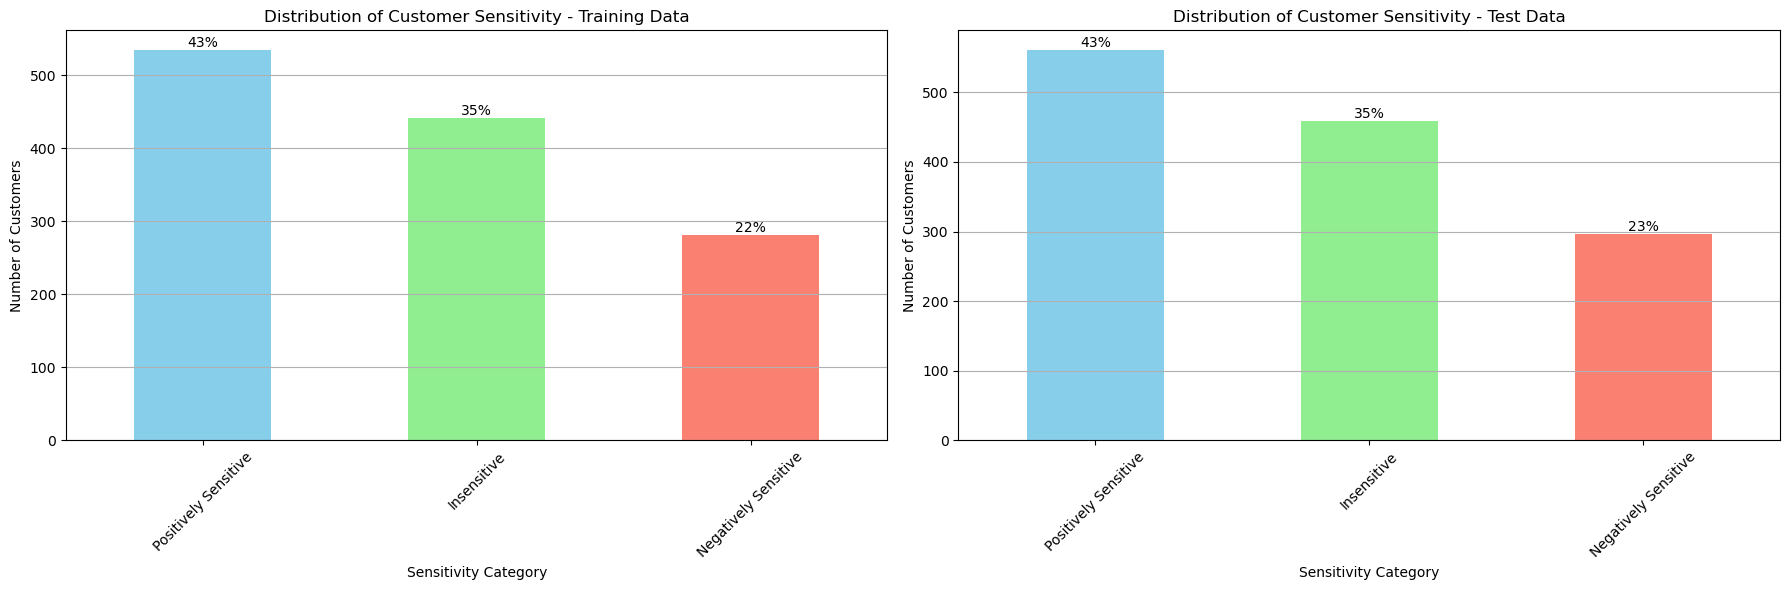

In [99]:
import matplotlib.pyplot as plt

# Assuming sensitivity_counts_test and sensitivity_counts_train have been correctly calculated as shown:
sensitivity_counts_test = test_customer_sensitivity['Sensitivity_Classification'].value_counts()
sensitivity_counts_train = customer_metrics_df['Sensitivity_Classification'].value_counts()

plt.figure(figsize=(18, 6))

# Plot for Training Data
plt.subplot(1, 2, 1)
bars_train = sensitivity_counts_train.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Customer Sensitivity - Training Data')
plt.xlabel('Sensitivity Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')

total_customers_train = customer_metrics_df['Sensitivity_Classification'].count()
for index, value in enumerate(sensitivity_counts_train):
    percentage = f'{(value / total_customers_train) * 100:.0f}%'
    plt.text(index, value, percentage, ha='center', va='bottom')

# Plot for Test Data
plt.subplot(1, 2, 2)
bars_test = sensitivity_counts_test.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Customer Sensitivity - Test Data')
plt.xlabel('Sensitivity Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')

total_customers_test = test_customer_sensitivity['Sensitivity_Classification'].count()
for index, value in enumerate(sensitivity_counts_test):
    percentage = f'{(value / total_customers_test) * 100:.0f}%'
    plt.text(index, value, percentage, ha='center', va='bottom')

plt.tight_layout()
plt.show()



We can also see very similar overlap between training and test meaning my function has worked! 

## Result

In [100]:
print(f"Total customers in test: {total_customers_test}")
print(f"Total customers in test that used a coupon: {total_test_customers_who_used_coupon}")
print(f"Total customers in test that used a coupon and had {coupon_trips+1} or more visits where they used a coupon: {customers_with_more_than_3_coupon_uses}\n")

print(f"Of these {sensitivity_counts.Insensitive} or {round(((sensitivity_counts.Insensitive/total_customers)*100),1)}% are Insensitive ")
print(f"Of these {sensitivity_counts['Positively Sensitive']} or {round(((sensitivity_counts['Positively Sensitive']/total_customers)*100),1)}% are Positively Sensitive")
print(f"Of these {sensitivity_counts['Negatively Sensitive']} or {round(((sensitivity_counts['Negatively Sensitive']/total_customers)*100),1)}% are Negatively Sensitive")

Total customers in test: 1317
Total customers in test that used a coupon: 2490
Total customers in test that used a coupon and had 5 or more visits where they used a coupon: 1940

Of these 456 or 36.5% are Insensitive 
Of these 528 or 42.2% are Positively Sensitive
Of these 267 or 21.3% are Negatively Sensitive


In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Num GPUs Available:  0
Please install GPU version of TF
